# Исследование алгоритмов кластеризации

In [55]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


# Импорт библиотек

In [56]:
import re
import string

import seaborn as sns
import spacy
import wget
from loguru import logger
import tqdm
import nltk
import numpy as np
import gensim,  logging
import pandas as pd
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA 
from sklearn.feature_extraction.text import CountVectorizer
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.fasttext import FastText
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt 

# Функции предобработки текста

### Токенизация, лемматизация, приведение к нижнему регистру

In [3]:
def preprocess_text(
                    text, 
                    nlp,
                    punctuation, 
                    stop_words
                    ):
    doc = nlp(text.lower())  # Привести к нижнему регистру и лемматизировать
    lemmatized_words = [token.lemma_ + "_" + token.pos_ for token in doc if token.text not in punctuation and token.text not in stop_words 
                        and token.pos_ not in ["PUNCT", "SYM", "SPACE"] and len(token.text) > 2]
    return " ".join(lemmatized_words)

### Удаление стоп-слов, пунктуации, возвращает массив обработанных документов

In [4]:
def tokenize(
            documents: str
            ):
    nlp = spacy.load("ru_core_news_sm")
    nltk.download('stopwords')
    nltk.download('punkt')
    stop_words = set(stopwords.words('russian'))
    punctuation = set(string.punctuation)
    processed_text = []
    for text in documents:
        preprocessed_text = preprocess_text(text, nlp, punctuation, stop_words)
        # print("Оригинальный текст:", text)
        # print("Предобработанный текст:", preprocessed_text)
        # print("<----------------------------------------------->")
        processed_text.append(preprocessed_text)
    return processed_text 

# Методы векторизации текста

## Простые векторные представления

### TF-IDF векторизация документов

In [5]:
def tfidf_vectorizer(processed_text):
    tfidf = TfidfVectorizer(smooth_idf = True, norm = 'l2',  ngram_range = (2,2))  
    tfidf_matrix = tfidf.fit_transform(processed_text)
    important_words = tfidf.get_feature_names_out()
    # print("Метод векторизации TF-IDF:")
    # print("Важные слова:", important_words)
    return tfidf_matrix

### Векторизация методом BagOfWords

In [6]:
def count_vectorizer(processed_text):
    count_vectorizer = CountVectorizer(analyzer = 'word', ngram_range = (2,2))
    token_counter = count_vectorizer.fit_transform(processed_text)
    cv_features = count_vectorizer.get_feature_names_out()
    print("Метод векторизации BoW:")
    cv_dataframe = pd.DataFrame(token_counter.toarray(), columns = cv_features)
    return cv_dataframe

## Сложные векторные представления

### Word2Vec

#### Векторизация

In [7]:
def W2V_vectorizer(
                    dataframe, 
                    model
                    ):
    model_name = model
    dataframe['tokens'] = [doc.split() for doc in tokenize(dataframe.text.tolist())]
    tokens_col = dataframe['tokens'].tolist()
    model = gensim.models.KeyedVectors.load_word2vec_format(model_name, binary = True)
    features = []
    for tokens in tokens_col:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model:
                try:
                    vectors.append(model[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    dataframe['vectors'] = features
    print("Метод векторизации Word2Vec")
    print("Количество векторов: ", len(features))
    print("Длина вектора: ", len(features))
    print
    return features

#### Обучениее модели

In [8]:
def W2V_training(dataframe):
    logger.debug("Токенизация....")
    dataframe['tokens'] = [doc.split() for doc in tokenize(dataframe.text.tolist())]
    logger.success("Токенизация завершена успешно!")
    tokens_col = dataframe['tokens'].tolist()
    #1 - skipgram, 0 -cbow
    for algorithm in range(0,1):
        if algorithm == 0:
            logger.debug("Обучение методом CBOW")
            model = gensim.models.Word2Vec(window=40, min_count=2, workers=3, vector_size=300, sg=algorithm)
            model.build_vocab(dataframe['tokens'])
            logger.debug(f"Количество строк в корпусе: {model.corpus_count}")
            logger.debug("Обучение...")
            model.train(dataframe['tokens'],  epochs=model.epochs, total_examples=model.corpus_count)
            logger.success("Обучение завершено!")
            model_filename = f"w2v_cbow_{model.corpus_count}.bin"
            model.wv.save_word2vec_format(model_filename, binary=True)
            logger.success(f"Модель сохранена в {model_filename}")
            
        logger.debug("Обучение методом SkipGram")
        model = gensim.models.Word2Vec(window=40, min_count=2, workers=3, vector_size=300, sg=algorithm)
        model.build_vocab(dataframe['tokens'])
        logger.debug(f"Количество строк в корпусе: {model.corpus_count}")
        logger.debug("Обучение...")
        model.train(dataframe['tokens'],  epochs=model.epochs, total_examples=model.corpus_count)
        logger.success("Обучение завершено!")
        model_filename = f"w2v_skipgram_{model.corpus_count}.bin"
        model.wv.save_word2vec_format(model_filename, binary=True)
        logger.success(f"Модель сохранена в {model_filename}")

### FastText

In [9]:
def FastText_training(dataframe):
    dataframe['tokens'] = [doc.split() for doc in tokenize(dataframe.text.tolist())]
    tokens_col = dataframe['tokens'].tolist()
    
    #    Параметры модели
    embedding_size = 100
    window_size = 40
    min_word = 5
    down_sampling = 1e-2
    
    ft_model = FastText(tokens_col,
                      vector_size=embedding_size,
                      window=window_size,
                      min_count=min_word,
                      sample=down_sampling,
                      sg=1,
                      epochs=20)
    
    semantically_similar_words = {words: [item[0] for item in ft_model.wv.most_similar([words], topn=5)]
                  for words in ['я_NOUN', 'приехать_VERB', 'москва_PROPN', 'фотографировать_VERB', 'красиво_ADJ']}

    for k,v in semantically_similar_words.items():
        print(k+":"+str(v))

### Glove

# Методы кластеризации текста

## Вычисление оптимального количества кластеров. Метод локтя

In [10]:
def elbow_method(scaled_df):
    kmeans_kwargs = {
                    "init": "random",
                    "n_init": 10,
                    "random_state": 1,
                    }
    
    #create list to hold SSE values for each k
    sse = []
    for k in range(1, 11):
        kmeans = KMeans(n_clusters = k, **kmeans_kwargs)
        kmeans.fit(scaled_df)
        sse.append(kmeans.inertia_)
    
    #visualize results
    plt.plot(range(1, 11), sse)
    plt.xticks(range(1, 11))
    plt.xlabel("Число кластеров")
    plt.ylabel("SSE")
    plt.show()

## K-Means

In [11]:
def kmeans_clusterization(
                            vectorized_text, 
                            n_clusters
                            ):
    #Инициализация метода главных компонент
    kmeans = KMeans(n_clusters = n_clusters, random_state = 42)
    clusters = kmeans.fit_predict(vectorized_text)
    print(f"For number of {n_clusters}:")
    print(f"Silhouette Coefficient: {metrics.silhouette_score(vectorized_text, clusters):.3f}")
    print(f"Inertia:{kmeans.inertia_}")


## MBK-Means

In [12]:
def mbkmeans_clusterization(
        X, 
        k, 
        mb, 
        print_silhouette_values, 
    ):
    """Generate clusters and print Silhouette metrics using MBKmeans

    Args:
        X: Matrix of features.
        k: Number of clusters.
        mb: Size of mini-batches.
        print_silhouette_values: Print silhouette values per cluster.

    Returns:
        Trained clustering model and labels based on X.
    """
    km = MiniBatchKMeans(n_clusters = k, batch_size = mb).fit(X)
    print(f"For n_clusters = {k}")
    print(f"Silhouette coefficient: {silhouette_score(X, km.labels_):0.2f}")
    print(f"Inertia:{km.inertia_}")

    if print_silhouette_values:
        sample_silhouette_values = silhouette_samples(X, km.labels_)
        print(f"Silhouette values:")
        silhouette_values = []
        for i in range(k):
            cluster_silhouette_values = sample_silhouette_values[km.labels_ == i]
            silhouette_values.append(
                (
                    i,
                    cluster_silhouette_values.shape[0],
                    cluster_silhouette_values.mean(),
                    cluster_silhouette_values.min(),
                    cluster_silhouette_values.max(),
                )
            )
        silhouette_values = sorted(
            silhouette_values, key =lambda tup: tup[2], reverse=True
        )
        for s in silhouette_values:
            print(
                f"    Cluster {s[0]}: Size:{s[1]} | Avg:{s[2]:.2f} | Min:{s[3]:.2f} | Max: {s[4]:.2f}"
            )
    return km, km.labels_

## DBScan

In [13]:
def dbscan_clusterization(
                            X, 
                            eps, 
                            min_samples
                            ):
    db = DBSCAN(eps = eps, min_samples = min_samples).fit(X)
    labels = db.labels_
    
    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)
    
    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

# Чтение датасета

In [14]:
news_df = pd.read_csv('lenta-ru-news.csv', delimiter =',', low_memory = True)

C:\Users\Doskin\AppData\Local\Temp\ipykernel_11828\3500316091.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  news_df = pd.read_csv('lenta-ru-news.csv', delimiter =',', low_memory = True)


In [47]:
news_df

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18
...,...,...,...,...,...,...
800970,https://lenta.ru/news/2019/12/14/shnur/,Шнуров раскритиковал Гагарину на «Голосе»,Певец Сергей Шнуров раскритиковал свою коллегу...,NaN,ТВ и радио,2019/12/14
800971,https://lenta.ru/news/2019/12/14/dolg/,В России предложили изменить правила взыскания...,Министерство юстиции России предложило изменит...,NaN,Все,2019/12/14
800972,https://lenta.ru/news/2019/12/14/dark_euro/,В России назвали «черную дату» для Европы,Испытание США ранее запрещенной Договором о ли...,NaN,Политика,2019/12/14
800973,https://lenta.ru/news/2019/12/14/meteo/,Россиянам пообещали аномально теплую погоду,В ближайшие дни в европейской части России пог...,NaN,Общество,2019/12/14


In [16]:
logger.success(f'Теги новостей: {news_df["tags"].unique()}, Количество: {len(news_df["tags"].unique())}')
logger.error(f'Темы новостей: {news_df["topic"].unique()}, Количество: {len(news_df["topic"].unique())}')

2024-03-12 21:07:22.251 | SUCCESS  | __main__:<module>:1 - Теги новостей: ['Первая мировая' 'Все' nan 'Прибалтика' 'Кино' 'Преступность' 'Общество'
 'Происшествия' 'Искусство' 'Бизнес' 'Техника' 'ТВ и радио' 'Политика'
 'Пресса' 'Музыка' 'Люди' 'Звери' 'Игры' 'Госэкономика' 'Гаджеты' 'Наука'
 'Еда' 'Рынки' 'Деньги' 'Летние виды' 'Интернет' 'Театр' 'Конфликты'
 'Реклама' 'Космос' 'Бокс и ММА' 'Футбол' 'Книги' 'Зимние виды'
 'Достижения' 'Coцсети' 'Вещи' 'События' 'Средняя Азия' 'Украина'
 'Закавказье' 'Белоруссия' 'Молдавия' 'Софт' 'Квартира' 'Город' 'Дача'
 'Офис' 'Оружие' 'Мнения' 'Москва' 'Регионы' 'Полиция и спецслужбы'
 'Криминал' 'Следствие и суд' 'Движение' 'Производители' 'Мировой бизнес'
 'Финансы компаний' 'Деловой климат' 'Мир' 'Россия' 'Часы' 'Явления'
 'Стиль' 'Инструменты' 'Вооружение' 'Вкусы' 'Страноведение'
 'Госрегулирование' 'История' 'Внешний вид' 'Автобизнес' 'Аналитика рынка'
 'Туризм' 'Выборы' 'Экология' 'Мемы' 'Мировой опыт' 'Инновации' 'Хоккей'
 'Вирусные ролики'

In [48]:
actual_news_df = pd.read_csv('lenta_ru_news_2019_2023.csv', delimiter =',', low_memory = True)

In [50]:
actual_news_df = actual_news_df.dropna()

In [51]:
actual_news_df["tags"] = actual_news_df["tags"].replace("Украина", "СВО/Украина")
actual_news_df

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2019/12/15/prsm/,Россиянам дали советы по выбору чая,Россиянам дали советы при выборе чая. Рекоменд...,Россия,Общество,2019-12-15
1,https://lenta.ru/news/2019/12/15/fb/,В Госдуме назвали японское заявление о Курилах...,Спикер Госдумы Вячеслав Володин назвал угрозой...,Россия,Политика,2019-12-15
2,https://lenta.ru/news/2019/12/15/kino/,Украинская ЛГБТ-активистка обвинила ню-фотогра...,Украинская ЛГБТ-активистка Виктория Гуйвик обв...,Культура,Фотография,2019-12-15
3,https://lenta.ru/news/2019/12/15/alba/,Полицейские застрелили порезавшего мать буйног...,В Москве полицейские застрелили мужчину при по...,Силовые структуры,Криминал,2019-12-15
4,https://lenta.ru/news/2019/12/15/anons/,Беглого президента Боливии решили арестовать,Исполняющая обязанности президента Боливии Жан...,Мир,Политика,2019-12-15
...,...,...,...,...,...,...
496252,https://lenta.ru/news/2024/01/01/braziliya-pri...,Пушилин сообщил о раненых в результате обстрел...,Глава Донецкой народной республики (ДНР) Денис...,Бывший СССР,СВО/Украина,2024-01-01
496253,https://lenta.ru/news/2024/01/01/eks-glava-mid...,В России подняли призывной возраст до 30 лет,С 1 января 2024 года начал действовать закон о...,Россия,Политика,2024-01-01
496254,https://lenta.ru/news/2024/01/01/na-ukraine-vy...,В России изменились условия выдачи материнског...,С 1 января 2024 года материнский капитал будут...,Россия,Политика,2024-01-01
496255,https://lenta.ru/news/2024/01/01/pushilin-soob...,На Украине высказались о возможной смене власти,Директор Украинского института анализа и менед...,Бывший СССР,СВО/Украина,2024-01-01


In [43]:
actual_news_df[actual_news_df["text"].str.contains("Бахмут")]

,url,title,text,topic,tags,date
8652,https://lenta.ru/news/2020/01/30/bread/,Украина заявила о прибывших в Донбасс снайпера...,"Украина заявила, что на Донбасс прибыли дополн...",Бывший СССР,Украина,2020-01-30
74173,https://lenta.ru/news/2020/10/29/podrobnosti/,Украинец 500 раз ударил ножом своего приятеля,Пожилой житель украинского Бахмута нанес своем...,Бывший СССР,Украина,2020-10-29
89653,https://lenta.ru/news/2020/12/29/croatia_quake/,На Украине бывший депутат пытался заказать уби...,Украинские силовики задержали бывшего депутата...,Бывший СССР,Украина,2020-12-29
93032,https://lenta.ru/news/2021/01/17/samolet/,Украинец поиграл в снежки возле памятника и по...,В городе Измаил Одесской области Украины мужчи...,Бывший СССР,Украина,2021-01-17
97162,https://lenta.ru/news/2021/02/03/afrika/,В Донбассе появится Нью-Йорк,В Донбассе появится Нью-Йорк. Это название при...,Бывший СССР,Украина,2021-02-03
...,...,...,...,...,...,...
491438,https://lenta.ru/news/2023/12/20/model-victori...,На Украине опровергли заявления о дефиците сна...,Экс-депутат Верховной Рады Игорь Лапин в интер...,Бывший СССР,Украина,2023-12-20
491664,https://lenta.ru/news/2023/12/20/zaharova-vysk...,ВСУ организовали артиллерийские склады в домах...,Вооруженные силы Украины (ВСУ) организовали ск...,Бывший СССР,Украина,2023-12-20
491805,https://lenta.ru/news/2023/12/20/novogodniy-fi...,Бойцы ВСУ признались в мрачном настроении из-з...,Настроение бойцов Вооруженных сил Украины (ВСУ...,Бывший СССР,Украина,2023-12-20
493426,https://lenta.ru/news/2023/12/24/v-ssha-zayavi...,Украину предупредили о способности России унич...,Дополнительные укрепления украинской армии не ...,Мир,Политика,2023-12-24


In [20]:
logger.success(f'Теги новостей: {actual_news_df["tags"].unique()}, Количество: {len(news_df["tags"].unique())}')
logger.error(f'Темы новостей: {actual_news_df["topic"].unique()}, Количество: {len(news_df["topic"].unique())}')

2024-03-12 21:07:42.557 | SUCCESS  | __main__:<module>:1 - Теги новостей: ['Общество' 'Политика' 'Фотография' 'Криминал' 'Интернет' 'Происшествия'
 'Музыка' nan 'Мнения' 'Наука' 'Мир' 'Закавказье' 'Пресса' 'Гаджеты'
 'Россия' 'Полиция и спецслужбы' 'Футбол' 'Зимние виды' 'Звери' 'Кино'
 'Белоруссия' 'Бокс и ММА' 'Стиль' 'ТВ и радио' 'Социальная сфера'
 'Оружие' 'Украина' 'Следствие и суд' 'Космос' 'Летние виды'
 'Госэкономика' 'Хоккей' 'Регионы' 'Люди' 'Искусство' 'Город' 'Все'
 'Прибалтика' 'История' 'Экономика' 'Деловой климат' 'Дом' 'Внешний вид'
 'Бизнес' 'Конфликты' 'Coцсети' 'Театр' 'Рынки' 'Средняя Азия' 'Явления'
 'Культура' 'События' 'Здоровье' 'Техника' 'Игры' 'Киберпреступность'
 'Софт' 'Преступность' 'Капитал' 'Еда' 'Книги' 'Преступная Россия'
 'Москва' 'Реклама' 'Достижения' 'Мемы' 'Авто' 'Молдавия' 'Экология'
 'Туризм' 'Вооружение' 'Финансы компаний' 'Мировой бизнес'
 '69-я параллель' 'Персоны' 'Счастливчики' 'Аномалии' 'Сериалы' 'Роскошь'
 'Личности' 'Климат и экология' 

In [68]:
actual_news_df["tags"].value_counts().reset_index().to_csv('tags_value_counts.csv', encoding='cp1251')

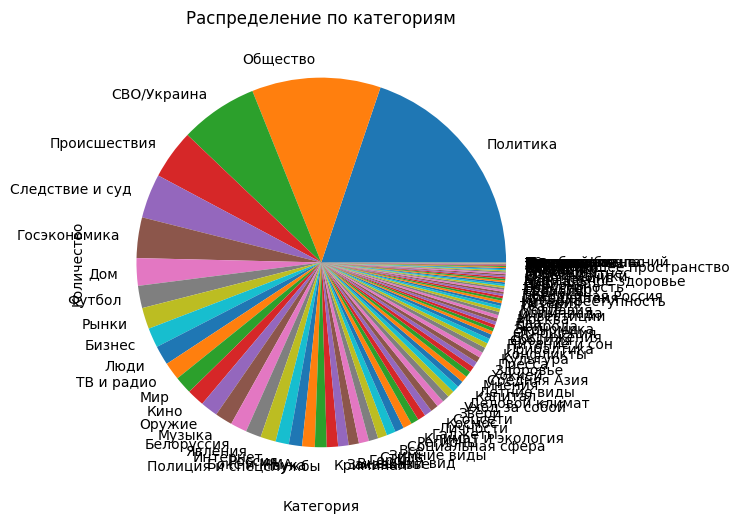

In [70]:
category_counts = actual_news_df['tags'].value_counts()

# Создание графика
plt.figure(figsize=(10, 6))
category_counts.plot(kind='pie')
plt.title('Распределение по категориям')
plt.xlabel('Категория')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()

In [140]:
actual_news_df['date'] = pd.to_datetime(actual_news_df['date'])

# Группировка данных по дате и подсчет количества событий в день
events_per_day = actual_news_df.groupby('date').size()

# Создание графика
plt.figure(figsize=(12, 6))
plt.plot(events_per_day.index, events_per_day.values, color='red')
plt.title('Количество событий по дням')

plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.grid(True)
plt.xticks(rotation=45, np.arange(0, max(events_per_day.values), 100))
plt.yticks(np.arange(0, max(events_per_day.values), 100))
plt.show()

SyntaxError: positional argument follows keyword argument (1807861679.py, line 14)

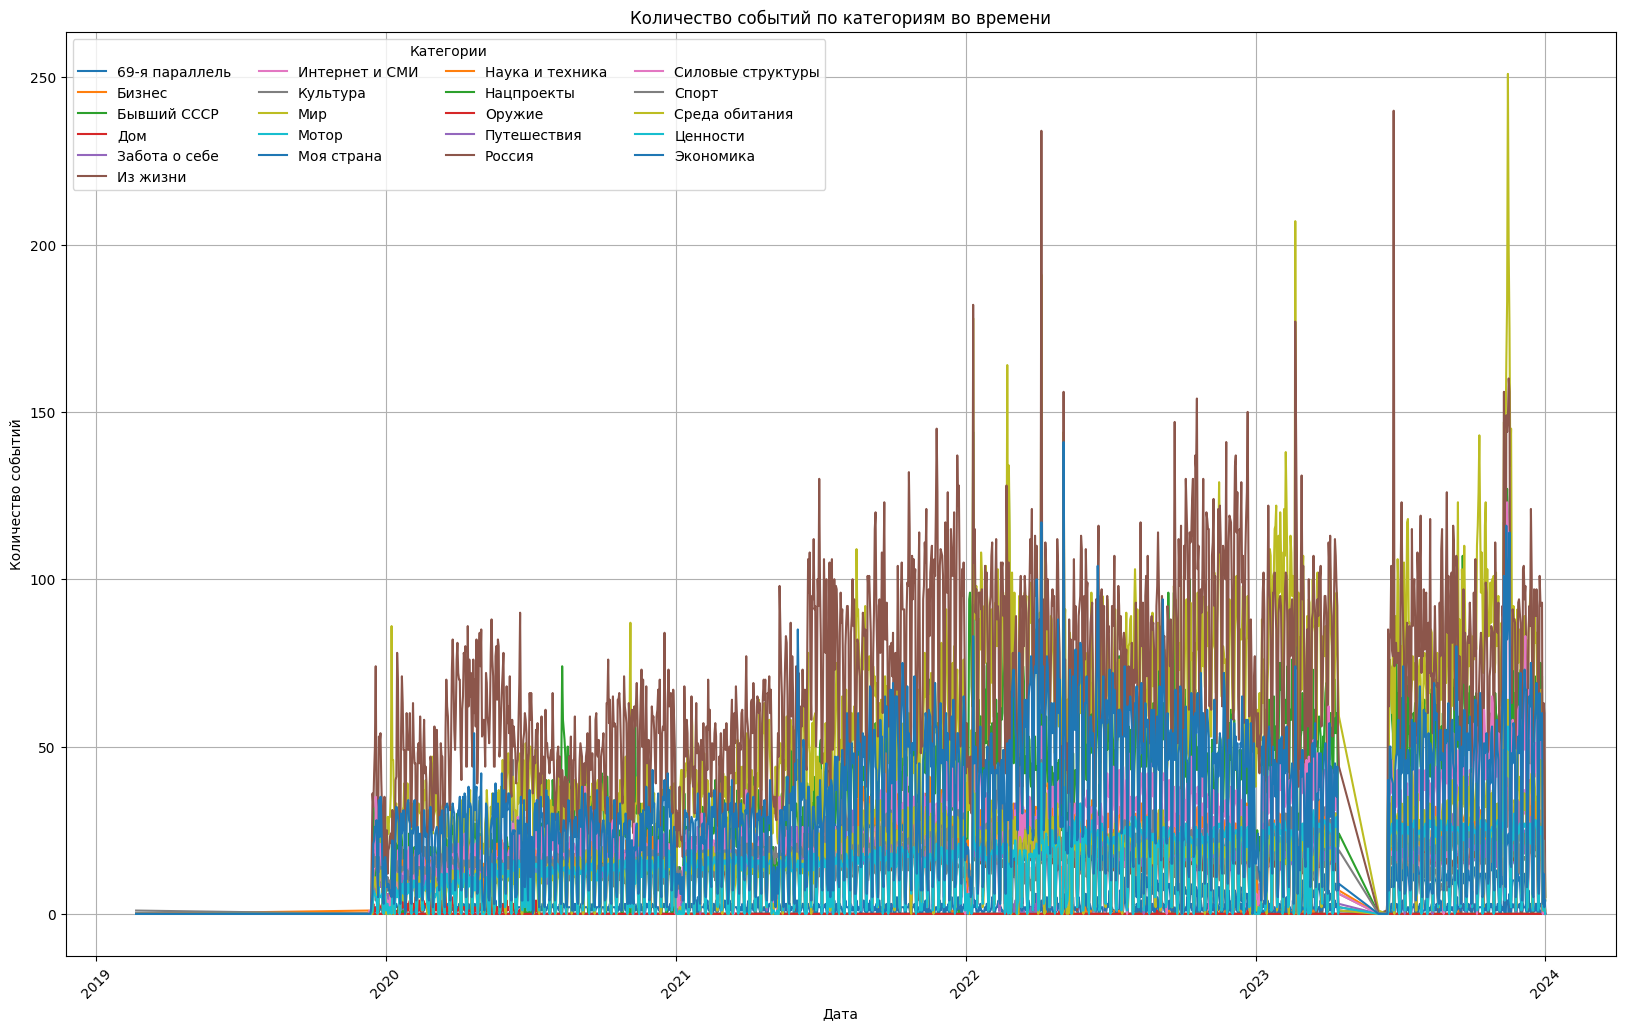

In [101]:
actual_news_df['date'] = pd.to_datetime(actual_news_df['date'])

# Создание сводной таблицы с количеством событий по датам и категориям
pivot_table = actual_news_df.pivot_table(index='date', columns='topic', aggfunc='size', fill_value=0)
pivot_table
# Построение линейного графика
plt.figure(figsize=(20, 12))
for column in pivot_table.columns:
    col = (np.random.random (), np.random.random (), np.random.random ())
    plt.plot(pivot_table.index, pivot_table[column], label=column)

plt.title('Количество событий по категориям во времени')
plt.plot()
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.legend(loc='upper left', ncols=4, title="Категории")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [92]:
cut_df = news_df[['text', 'topic']].head(1500)
cut_df
logger.debug(f'Теги новостей: {cut_df["topic"].unique()}, Количество: {len(cut_df["topic"].unique())}')

2024-03-12 22:35:26.386 | DEBUG    | __main__:<module>:3 - Теги новостей: ['Библиотека' 'Россия' 'Мир' 'Экономика' 'Интернет и СМИ'], Количество: 5


## TF-IDF векторизация

In [ ]:
X_tfidf = tfidf_vectorizer(tokenize(cut_df['text']))

### K-means

In [ ]:
kmeans_clusterization(vectorized_text = X_tfidf,
                      n_clusters=4
                     )

### MiniBatchKMeans

In [ ]:
clustering, cluster_labels = mbkmeans_clusterization(
	X=X_tfidf,
    k=2,
    mb=500,
    print_silhouette_values=True,
)

### DBSCAN

In [ ]:
dbscan_clusterization(X=X_tfidf,
                      eps=1,
                      min_samples= 3  
                     )

In [ ]:
%%time
FastText_training(cut_df)

## Word2Vec векторизацияя

In [ ]:
%%time
W2V_training(cut_df)

### SkipGram

In [ ]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
skipgram_vectorized_docs = W2V_vectorizer(cut_df, "w2v_skipgram_1500.bin")

In [ ]:
dbscan_clusterization(X=skipgram_vectorized_docs,
                      eps=0.3,
                      min_samples=5
                      )

In [ ]:
elbow_method(vectorized_docs)

In [ ]:
clustering, cluster_labels = mbkmeans_clusterization(
	X=skipgram_vectorized_docs,
    k=4,
    mb=400,
    print_silhouette_values=True,
)

### CBOW

In [ ]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
cbow_vectorized_docs = W2V_vectorizer(cut_df, "w2v_cbow_1500.bin")

In [ ]:
clustering, cluster_labels = mbkmeans_clusterization(
	X=cbow_vectorized_docs,
    k=4,
    mb=500,
    print_silhouette_values=True
)

In [ ]:
dbscan_clusterization(X=cbow_vectorized_docs,
                      eps=0.3,
                      min_samples=5
                      )